# Analysis of Carbon Emissions in the US

Grace Shevchuk

For this tutorial, we will be walking through creating a predictive model for carbon dioxide emissions using walkability index and population. The goal of this tutorial is to see how well these two variables can predict CO2 emissions, as many times, responsibility for climate change is pushed onto the individual, with pressure to change their lifestyle to reduce their carbon footprint. 

CO2 emissions is a pressing concern with the steady approach of [climate change](https://science.nasa.gov/climate-change/what-is-climate-change/). Carbon dioxide is a [greenhouse gas](https://climate.mit.edu/explainers/greenhouse-gases), meaning that it traps heat on Earth. Earth has something in place that regulates the amount of CO2 in the atmosphere, which is the [carbon cyle](https://education.nationalgeographic.org/resource/carbon-cycle/), however, humans have been releasing more CO2 into the atmosphere than the carbon cycle can keep up with, which, if not addressed, can lead to a [runaway greenhouse effect](https://climate.nasa.gov/news/2534/scientists-assess-potential-for-super-greenhouse-effect-in-earths-tropics/), like what likely occurred on Venus. This is why, even though Earth has had warm, and cold, periods in the past, current climate change is alarming. 

A lot of focus on curbing climate change has been on the individual, with [electric car incentives](https://www.edmunds.com/electric-car/tax-credits-rebates-incentives/), [solar panel incentives](https://www.energy.gov/eere/solar/homeowners-guide-federal-tax-credit-solar-photovoltaics), and overall [pressure to reduce your carbon footprint](https://www.wired.com/story/reduce-carbon-footprint/) (the term first being used by BP, an oil company). While people should be trying to do what they can to live greener, does it really make a difference? Can individual action actually alleviate climate change? The goal of this tutorial is to find out. 

### Walkability Indices

[Walkability index](https://epa.maps.arcgis.com/home/webmap/viewer.html?webmap=f16f5e2f84884b93b380cfd4be9f0bba), which is a measure for how easy it is to walk around in an area, can help us see where in the US people are more likely to not drive. Places with higher walkability indices have been found to have greater environmental health. The EPA calculates the walkability index of an area with its intersection density, distance to transit stops, and diversity of land use. Population will go alongside walkability index, since the more people there are, the more CO2 emissions they release. 

### Data Collection

In this section, we will get the data we will be using for our analysis. We will be using a CO2 emission [dataset](https://www.epa.gov/ghgreporting/data-sets), a walkability index [dataset](https://catalog.data.gov/dataset/walkability-index1), and a population [dataset](https://www.census.gov/data/tables/time-series/dec/density-data-text.html). 

In [1]:
# the libraries we will be using
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import statsmodels.api as sm

In [2]:
# download the datasets, rename them, and put them on your desktop
# reading the datasets
emissions = pd.read_excel("Desktop/emissions.xlsx")
walkability = pd.read_csv("Desktop/walkability_index.csv")
population = pd.read_csv("Desktop/population.csv")

The next part involves isolating only the [features](https://en.wikipedia.org/wiki/Feature_(machine_learning)) from the datasets that we need. 

For the emissions dataset, which after the download got misformatted, we only need two columns: the 4th and the 14th ones. Also, the first three rows were used for labels, so we do not need those either. 

In [3]:
# select columns
emissions = emissions.rename(columns={"Unnamed: 4": "State", "Unnamed: 14": "CO2 Emissions"})
# rename columns
emissions = emissions[["State", "CO2 Emissions"]]
# drop rows
emissions = emissions.iloc[3:]
emissions.head()

,State,CO2 Emissions
3,TX,NaN
4,NY,44612.9
5,IL,246.9
6,TX,30540.4
7,MN,106144


In [4]:
walkability = walkability[["CBSA_Name", "NatWalkInd"]]
walkability = walkability.rename(columns={"CBSA_Name": "Location", "NatWalkInd": "Index"})
walkability.head()

,Location,Index
0,"Dallas-Fort Worth-Arlington, TX",14.000000
1,"Dallas-Fort Worth-Arlington, TX",10.833333
2,"Dallas-Fort Worth-Arlington, TX",8.333333
3,"Dallas-Fort Worth-Arlington, TX",15.666667
4,"Dallas-Fort Worth-Arlington, TX",10.166667


The population dataset contains data on multiple years. However, our other two data sets contain data only on one year (2019), so we will drop all the data not from 2020 (since the census happens every 10 years, this is the closest we can get to 2019). 

In [5]:
# drop prior years
population.drop(population[population.Year < 2020].index, inplace=True)
population = population[["Name", "Resident Population", "Resident Population Density"]]
population = population.rename(columns={"Name": "State", "Resident Population": "Population", 
                                        "Resident Population Density": "Population Density"})
population.head()

,State,Population,Population Density
627,Alabama,"5,024,279",99.2
628,Alaska,"733,391",1.3
629,Arizona,"7,151,502",62.9
630,Arkansas,"3,011,524",57.9
631,California,"39,538,223",253.7


### Data Processing

Now that we have our dataframes ready, we need to make sure that the data is usable. To start off, since the datasets were all from different sources, they do not share the same locations. The only measure for location they all share is state, so we will use that. The emissions dataframe has multiple observations for each state, so we will sum up the CO2 emissions for each state so that there is only one. This will also drop any missing data.  

In [6]:
# combine by states, summing emissions
emissions_aggregation = {"CO2 Emissions": "sum"}
emissions = emissions.groupby(emissions["State"]).aggregate(emissions_aggregation)
emissions.head()

,CO2 Emissions
State,
AK,13730822.2
AL,71395500.0
AR,39829349.3
AZ,48795719.5
CA,84486788.5


The walkability dataframe requires a bit more work. The city and state are in the same column, so we have to start by separating them. Also, since the data is grouped by [census block groups](https://www.census.gov/geographies/reference-maps/2020/geo/2020-census-block-maps.html), there are multiple cities and states for some observations. So, when we will also have to separate the states into different observations. Once we do this, we will also combine by states, but this time averaging the walkability index. 

To do this, we will use Pandas [concat](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.concat.html) and [explode](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.explode.html) functions. 

In [7]:
# split the location into states
walkability = pd.concat([walkability["Location"].str.split(', ', expand=True), walkability["Index"]], axis=1)
walkability = walkability.rename(columns={1: "State"})
walkability = walkability[["State", "Index"]]
# separate the different states
walkability["State"] = walkability["State"].str.split("-")
walkability = walkability.explode("State")
# combine by states, averaging walkability index
walkability_aggregation = {"Index": "mean"}
walkability = walkability.groupby(walkability["State"]).aggregate(walkability_aggregation)
walkability.head()

,Index
State,
AK,9.240997
AL,7.088054
AR,7.904707
AZ,10.225751
CA,12.279742


The previous two dataframes use state abbreviations, however the population dataframe uses the state's full name. So, we will have to replace each name with its abbreviations, using a free [state to abbreviation dictionary](https://gist.github.com/rogerallen/1583593).

In [8]:
# state to abbreviation dictionary
states = {
    "Alabama": "AL",
    "Alaska": "AK",
    "Arizona": "AZ",
    "Arkansas": "AR",
    "California": "CA",
    "Colorado": "CO",
    "Connecticut": "CT",
    "Delaware": "DE",
    "Florida": "FL",
    "Georgia": "GA",
    "Hawaii": "HI",
    "Idaho": "ID",
    "Illinois": "IL",
    "Indiana": "IN",
    "Iowa": "IA",
    "Kansas": "KS",
    "Kentucky": "KY",
    "Louisiana": "LA",
    "Maine": "ME",
    "Maryland": "MD",
    "Massachusetts": "MA",
    "Michigan": "MI",
    "Minnesota": "MN",
    "Mississippi": "MS",
    "Missouri": "MO",
    "Montana": "MT",
    "Nebraska": "NE",
    "Nevada": "NV",
    "New Hampshire": "NH",
    "New Jersey": "NJ",
    "New Mexico": "NM",
    "New York": "NY",
    "North Carolina": "NC",
    "North Dakota": "ND",
    "Ohio": "OH",
    "Oklahoma": "OK",
    "Oregon": "OR",
    "Pennsylvania": "PA",
    "Rhode Island": "RI",
    "South Carolina": "SC",
    "South Dakota": "SD",
    "Tennessee": "TN",
    "Texas": "TX",
    "Utah": "UT",
    "Vermont": "VT",
    "Virginia": "VA",
    "Washington": "WA",
    "West Virginia": "WV",
    "Wisconsin": "WI",
    "Wyoming": "WY",
    "District of Columbia": "DC",
    "American Samoa": "AS",
    "Guam": "GU",
    "Northern Mariana Islands": "MP",
    "Puerto Rico": "PR",
    "United States Minor Outlying Islands": "UM",
    "U.S. Virgin Islands": "VI",
}

population["State"] = population["State"].replace(states)
population.head()

,State,Population,Population Density
627,AL,"5,024,279",99.2
628,AK,"733,391",1.3
629,AZ,"7,151,502",62.9
630,AR,"3,011,524",57.9
631,CA,"39,538,223",253.7


If we look at the lengths of the different dataframes, we can see that they have different number of observations, and they even have more than 50, which is how many states are in the US. This is because they contain data on territories and Washington DC as well. 

In [9]:
print(len(emissions.index))
print(len(walkability.index))
print(len(population.index))

54
52
57


Since the focus of this analysis is on the US, it is okay to drop some territories that are not across all the dataframes. We will end up with 52 observations, which includes DC and Puerto Rico. So, we will combine the dataframes into one using [inner join](https://www.geeksforgeeks.org/different-types-of-joins-in-pandas/). 

In [10]:
df = emissions.merge(walkability, on="State", how="inner")
df = df.merge(population, on="State", how="inner")
df.head()

,State,CO2 Emissions,Index,Population,Population Density
0,AK,13730822.2,9.240997,"733,391",1.3
1,AL,71395500.0,7.088054,"5,024,279",99.2
2,AR,39829349.3,7.904707,"3,011,524",57.9
3,AZ,48795719.5,10.225751,"7,151,502",62.9
4,CA,84486788.5,12.279742,"39,538,223",253.7


Finally, we will separate our data in a [test and a train](https://en.wikipedia.org/wiki/Training,_validation,_and_test_data_sets) dataset. We will use the first 5 entries for test and the rest for train. 

In [11]:
test = df[:5]
train = df[5:]

### Data Visualization

Up next is [data visualization](https://www.datacamp.com/blog/what-is-data-visualization-a-guide-for-data-scientists). This will help us get a feel for the type of data we are working with, and give us a preview for any potential relationships. We will start off with graphing the CO2 emissions, walkability index, population, and population density for each state.

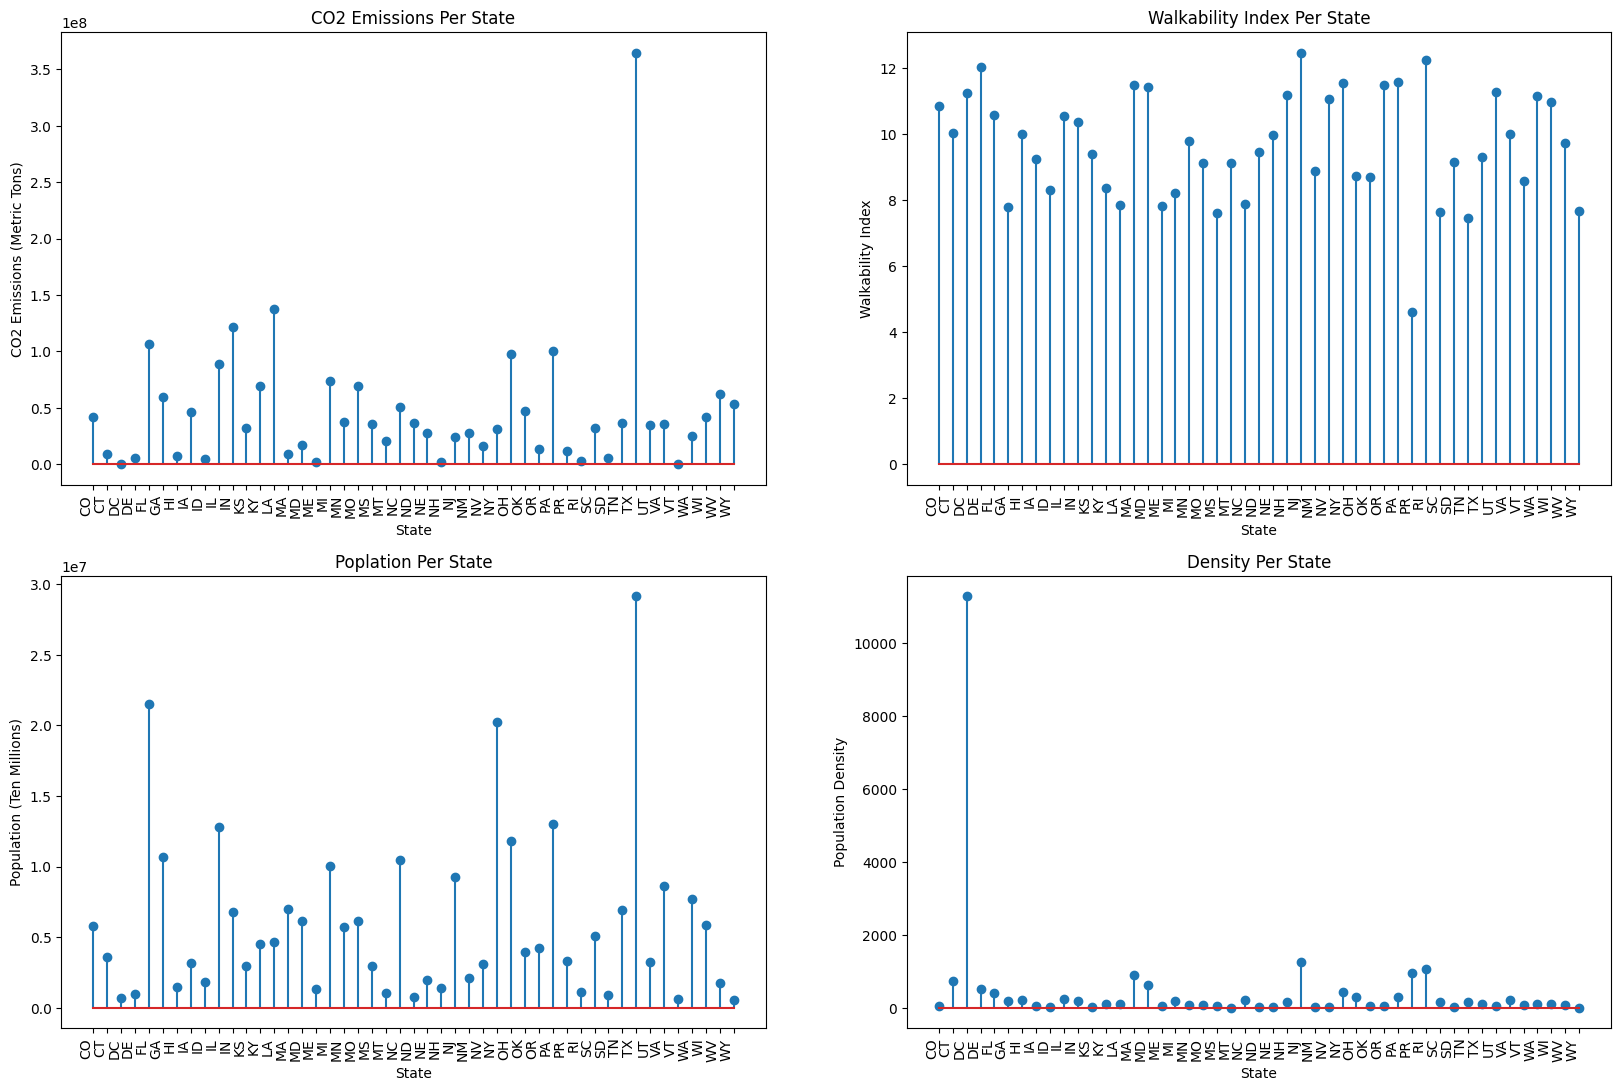

In [12]:
# separate the columns into lists for easier use
state = train["State"]
emission = train["CO2 Emissions"]
windex = train["Index"]
population = train["Population"]
density = train["Population Density"]

# make sure all of the values are floats
emission = [float(v) for v in emission]
windex = [float(v) for v in windex]
population = [float(v.replace(",", "")) for v in population]
density = [float(v.replace(",", "")) for v in density]

x_pos = np.arange(len(state))

# plotting the graphs
fig = plt.figure(figsize=(20,20))

# CO2 per state
gr1 = fig.add_subplot(3, 2, 1)
gr1.stem(state, emission)
gr1.set_title("CO2 Emissions Per State")
gr1.set_ylabel("CO2 Emissions (Metric Tons)")
gr1.set_xlabel("State")
temp = gr1.set_xticks(x_pos, labels=state)
temp = gr1.set_xticklabels(state, rotation=90, ha="right")

# walkability per state
gr2 = fig.add_subplot(3, 2, 2)
gr2.stem(state, windex)
gr2.set_title("Walkability Index Per State")
gr2.set_ylabel("Walkability Index")
gr2.set_xlabel("State")
temp = gr2.set_xticks(x_pos, labels=state)
temp = gr2.set_xticklabels(state, rotation=90, ha="right")

# population per state
gr3 = fig.add_subplot(3, 2, 3)
gr3.stem(state, population)
gr3.set_title("Poplation Per State")
gr3.set_ylabel("Population (Ten Millions)")
gr3.set_xlabel("State")
temp = gr3.set_xticks(x_pos, labels=state)
temp = gr3.set_xticklabels(state, rotation=90, ha="right")

# population density per state
gr4 = fig.add_subplot(3, 2, 4)
gr4.stem(state, density)
gr4.set_title("Density Per State")
gr4.set_ylabel("Population Density")
gr4.set_xlabel("State")
temp = gr4.set_xticks(x_pos, labels=state)
temp = gr4.set_xticklabels(state, rotation=90, ha="right")

Next, we will plot each of our independent variables vs our dependent variable. This will give us insight on if any of these pairs appear to have a [linear relationship](https://www.khanacademy.org/test-prep/v2-sat-math/x0fcc98a58ba3bea7:algebra-easier/x0fcc98a58ba3bea7:linear-equation-word-problems-easier/a/v2-sat-lesson-understanding-linear-relationships). 

Text(0.5, 0, 'Population Density')

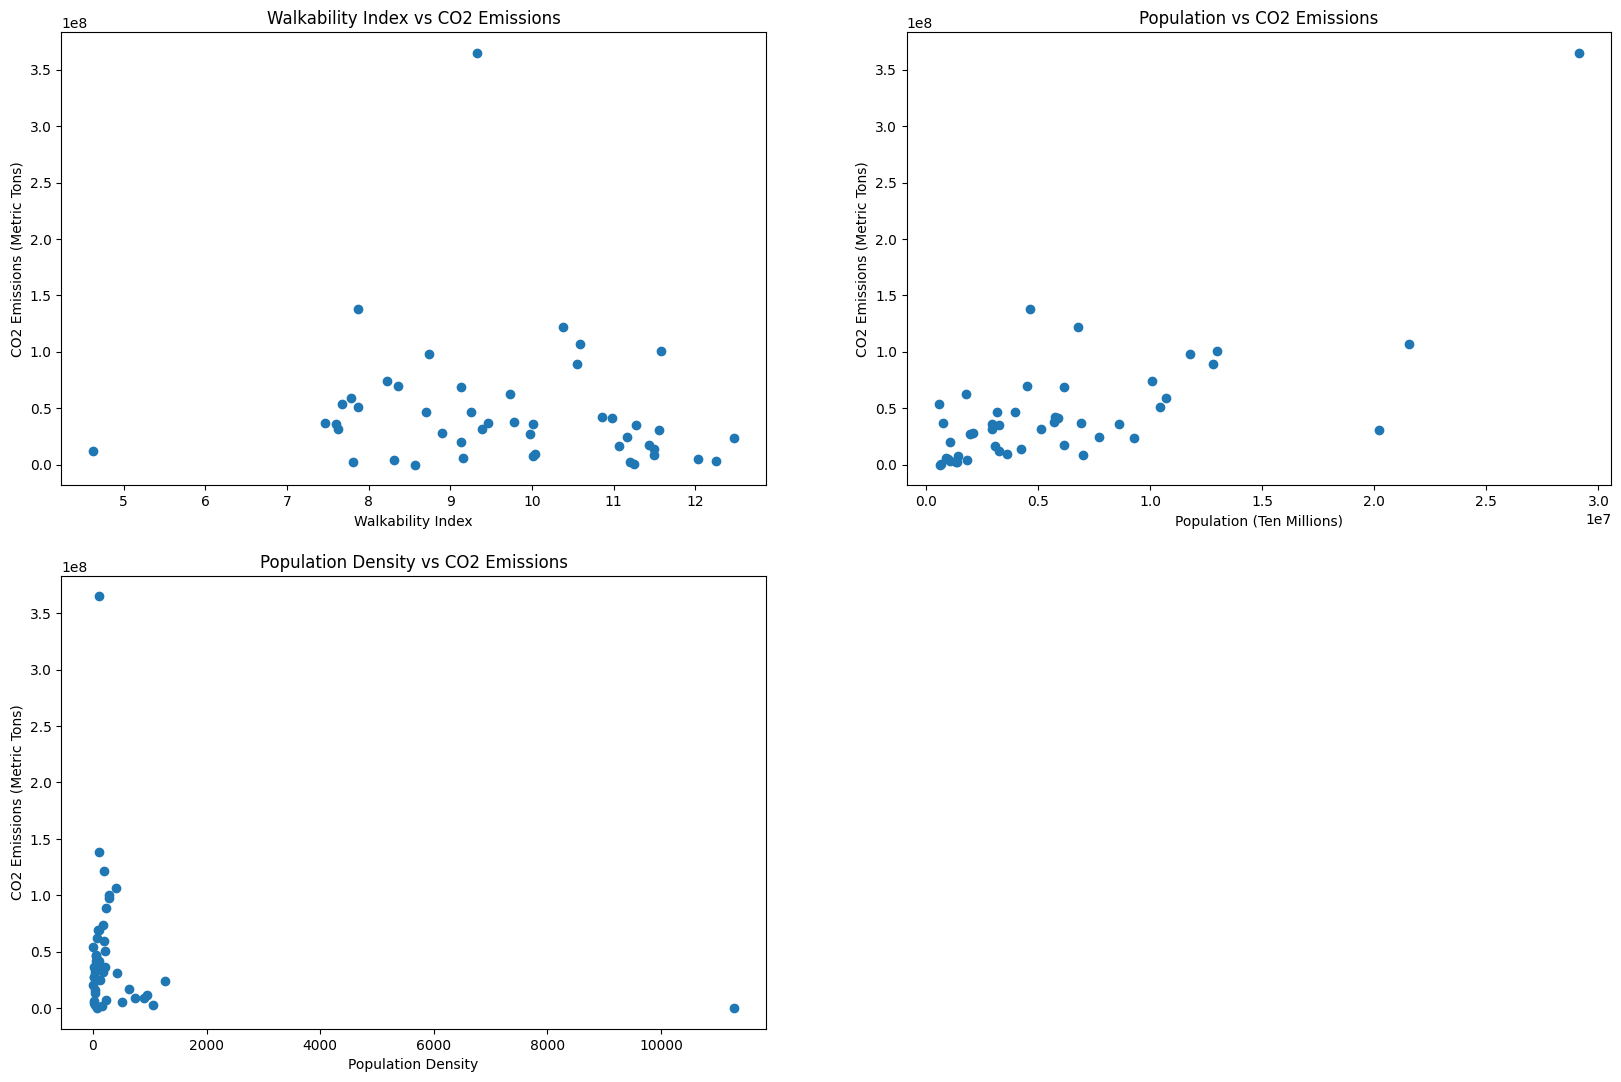

In [13]:
fig2 = plt.figure(figsize=(20,20))

# walkability vs emissions
gr4 = fig2.add_subplot(3, 2, 1)
gr4.scatter(windex, emission, marker="o")
gr4.set_title("Walkability Index vs CO2 Emissions")
gr4.set_ylabel("CO2 Emissions (Metric Tons)")
gr4.set_xlabel("Walkability Index")

# population vs emissions
gr5 = fig2.add_subplot(3, 2, 2)
gr5.scatter(population, emission, marker="o")
gr5.set_title("Population vs CO2 Emissions")
gr5.set_ylabel("CO2 Emissions (Metric Tons)")
gr5.set_xlabel("Population (Ten Millions)")

# population density vs emissions
gr6 = fig2.add_subplot(3, 2, 3)
gr6.scatter(density, emission, marker="o")
gr6.set_title("Population Density vs CO2 Emissions")
gr6.set_ylabel("CO2 Emissions (Metric Tons)")
gr6.set_xlabel("Population Density")

Looking at these graphs, population looks to have a weak linear relationship with CO2 emissions, however the other two features do not appear to do so. Lets do some further analysis to confirm these suspicions. 

### Analysis and Hypothesis Testing

We can start off by conducting linear regression and calculating the p value for each of these pairs. We can find the [p value](https://en.wikipedia.org/wiki/P-value) in the Prob (F-statistic) section of the regression results. 

In [14]:
# linear regression
x = [[x] for x in windex]
y = [[y] for y in emission]
# calculate p value
x2  = sm.add_constant(x)
est  = sm.OLS(y, x2)
_2  = est.fit()
print(_2.summary())

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.012
Model:                            OLS   Adj. R-squared:                 -0.010
Method:                 Least Squares   F-statistic:                    0.5442
Date:                Wed, 15 May 2024   Prob (F-statistic):              0.465
Time:                        09:48:25   Log-Likelihood:                -906.24
No. Observations:                  47   AIC:                             1816.
Df Residuals:                      45   BIC:                             1820.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const       8.433e+07   5.21e+07      1.619      0.1

P value is greater than 0.05, which means that the relationship between walkability index and CO2 emissions is not [statistically significant](https://en.wikipedia.org/wiki/Statistical_significance).

In [15]:
# linear regression
x = [[x] for x in population]
y = [[y] for y in emission]
# calculate p value
x2  = sm.add_constant(x)
est  = sm.OLS(y, x2)
_2  = est.fit()
print(_2.summary())

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.531
Model:                            OLS   Adj. R-squared:                  0.521
Method:                 Least Squares   F-statistic:                     50.96
Date:                Wed, 15 May 2024   Prob (F-statistic):           6.36e-09
Time:                        09:48:28   Log-Likelihood:                -888.73
No. Observations:                  47   AIC:                             1781.
Df Residuals:                      45   BIC:                             1785.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const       3.696e+06   8.39e+06      0.441      0.6

P value is less than 0.05, which means that the relationship between population and CO2 emissions is statistically significant.

In [16]:
# linear regression
x = [[x] for x in density]
y = [[y] for y in emission]
# calculate p value
x2  = sm.add_constant(x)
est  = sm.OLS(y, x2)
_2  = est.fit()
print(_2.summary())

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.021
Model:                            OLS   Adj. R-squared:                 -0.001
Method:                 Least Squares   F-statistic:                    0.9615
Date:                Wed, 15 May 2024   Prob (F-statistic):              0.332
Time:                        09:48:31   Log-Likelihood:                -906.03
No. Observations:                  47   AIC:                             1816.
Df Residuals:                      45   BIC:                             1820.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const       4.885e+07   8.84e+06      5.523      0.0

P value is greater than 0.05, which means that the relationship between population density and CO2 emissions is not statistically significant.

So, we have determined that walkability index and population density alone are not good predictors for CO2 emissions, however, in case of hidden interactions between the three independent variables, lets do [multivariate gradient descent regression](https://medium.com/@IwriteDSblog/gradient-descent-for-multivariable-regression-in-python-d430eb5d2cd8) to see if we can predict CO2 emissions using all three of the features. 

We will start off by [normalizing the data](https://en.wikipedia.org/wiki/Database_normalization), since population is in the millions while walkability index is under 20 and we want each of the variables to have an equal weight to begin with.

In [17]:
# get the variables
x = np.vstack((windex, population, density)).T
y = train['CO2 Emissions'].values.astype(float).reshape(-1,1)
m = len(y)

# add bias
X = np.concatenate((np.ones((len(x),1)),x),axis=1)
X.shape

# data normalization
Xnorm = X.copy()
minx = np.min(X[:,1:])
maxx = np.max(X[:,1:])
Xnorm[:,1:] = (X[:,1:]-minx)/(maxx-minx)
Xnorm[:10,:]

ynorm = y.copy()
maxy = np.max(y)
miny = np.min(y)
ynorm = (y-miny)/(maxy - miny) 
ynorm[:10,0]

# fill theta0 to begin with
theta0 = np.zeros((X.shape[1],1))+0.4

Here is our gradient descent function. It utilizes the multivariate gradient descent formula to calculate the coefficients and the intercept for our regression equation.

In [18]:
def grad_descent(theta0,T=.5,epochs=1000,alpha=1e-10):
    loss = []
    
    theta = theta0*10000
    for epoch in range(epochs):
        grad = 1/m*np.sum((Xnorm.dot(theta0)-ynorm)*Xnorm,axis=0).reshape(-1,1)
        l = (Xnorm.dot(theta0))[0]
        
        theta = theta0 - T*grad
        loss.append(l[0])
        
        if np.sum((theta - theta0)**2) < alpha:
            break
        theta0 = theta

    return theta,loss

Now lets call the gradient descent function to get the coefficients and the [loss](https://www.datacamp.com/tutorial/loss-function-in-machine-learning). 

In [19]:
theta,loss = grad_descent(theta0)

In [20]:
# coefficients
windexc = round(theta[1][0].astype(float), 20)
populationc = round(theta[2][0].astype(float), 20)
densityc = round(theta[3][0].astype(float), 20)
intercept = round(theta[0][0].astype(float), 20)

print("Walkability Index Weight: " + windexc.astype(str))
print("Population Weight: " + populationc.astype(str))
print("Population Density Weight: " + densityc.astype(str))
print("Intercept: " + intercept.astype(str))

Walkability Index Weight: 0.3999996686359904
Population Weight: 0.5743299946487312
Population Density Weight: 0.3998893385728279
Intercept: 0.009800273750664454


Lets also graph our loss. It should be shaped like an "L". 

Text(0.5, 1.0, 'Loss Function over Epochs')

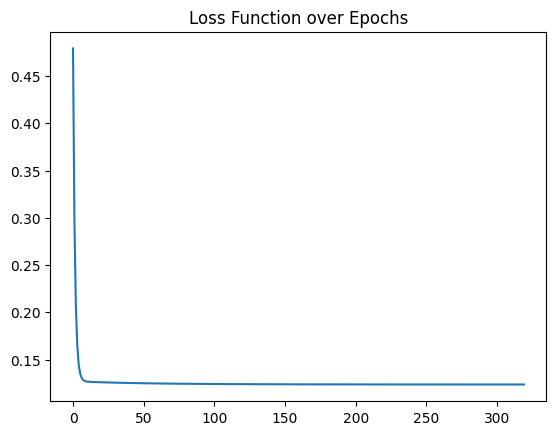

In [21]:
plt.plot(loss)
plt.title('Loss Function over Epochs')

Finally, lets test how well this regression can predict CO2 emissions based on walkability index, population, and population density. We will go back to that test dataset we created earlier on and plug in those values into our equation. We will also calculate the [mean squared error](https://en.wikipedia.org/wiki/Mean_squared_error), which will tell us how far our predictions are from the actual values. 

In [22]:
emissiont = test["CO2 Emissions"]
windext = test["Index"]
populationt = test["Population"]
densityt = test["Population Density"]

emissiont = [float(v) for v in emissiont]
windext = [float(v) for v in windext]
populationt = [float(v.replace(",", "")) for v in populationt]
densityt = [float(v.replace(",", "")) for v in densityt]

predicted = []
actual = []
mses = []

# calculate predicted values and MSE
for i in range(5):
    predicted.append(intercept + windexc*windext[i] + populationc*populationt[i] + densityc*densityt[i])
    actual.append(emissiont[i])
    mses.append((actual[i] - predicted[i])**2)

print(np.mean(mses))

2427198537922290.5


The MSE looks very high. Looking at the range of CO2 emissions from our training dataset, the error is high enough that it can make our lowest CO2 emission predicted into our highest. 

In [23]:
print(min(emission))
print(max(emission))

157578.0
364847108.69920635


### Insight

Our model is not able to accurately predict CO2 emissions by walkability index, population, and population density. Perhaps if our observations were done at a smaller scale, like by city instead of by state, our model may have been better, however due to our datasets this was not possible. This means that these variables are not good predictors for CO2 emissions. 

We also know that population has a linear relationship with CO2 emissions, so exploring other variables that may relate to population may help us develop a more robust model. Variables that are potentially better predictors for CO2 emissions are industrial density (amount of factories and manufacturing in an area), amount of flight traffic, and electricity production. All of these variables do seem to have a relationship with population intuitively, as factories bring jobs and more electricity is needed if there are more people. However, publicly available datasets containing this information were not able to be found, otherwise they would have been included in this tutorial. But, this is still a good area for future exploration. 

Even though our model was not a success, we can still take some insights from it. For one, less energy should be going into reducing the carbon footprints of households, and more should be going into making systemic changes that reduce CO2 emissions. Our analysis has showed us that whether an individual drives a gas car or bikes does not make a difference in the amount of CO2 emissions, so that should not be the focus of climate change action. 

Especially as climate change and CO2 emissions can lead to irreversible and catastrophic [results](https://ntrs.nasa.gov/citations/20020002197), it is important to target the biggest CO2 emitters. We know that the [way](https://www.npr.org/2021/11/30/1060185929/what-s-the-environmental-impact-each-time-we-hit-buy-now-and-can-we-change-cours) the US runs is a driving force for climate change, and large changes need to be made to help curb it, not [switching to electric cars](https://time.com/6341884/climate-change-consumption/).  